In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

import zipfile
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Общие функции

In [ ]:
def preprocess_text(text: str):
  text = (re.sub(r"([\d,!?'/:])", "", text)).lower()
  return text

In [ ]:
def train(dataloader, model, loss_fn, optimizer, epoch, reshape=False):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    total_samples = 0.0
    correct_samples = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if reshape:
          X = X.reshape(-1, 17*52)
        pred = model(X.type(torch.long))
        # torch.max(y, 1)[1]
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss
        total_samples += y.shape[0]
        _, prediction_indices = torch.max(pred, 1)
        correct_samples += torch.sum(prediction_indices==y)

    if epoch == 0 or (epoch+1)%5 == 0:
        print(f"train loss: {loss.item():>7f}")
    return float(correct_samples) / total_samples, (loss_sum / len(dataloader)).cpu().detach().numpy()

In [ ]:
def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if epoch == 0 or (epoch+1)%5 == 0:
      print(f"test: accuracy: {(100*correct):>0.1f}%, val loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
def train_test(train_dl, test_dl, model, loss_fn, optimizer, epochs=10, reshape=False):
  history = pd.DataFrame(columns=['epoch', 'train loss', 'train accuracy', 'val loss', 'test accuracy'])
  for epoch in range(epochs):
      if epoch == 0 or (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}:")
      train_acc, train_loss = train(train_dl, model, loss_fn, optimizer, epoch, reshape)
      test_acc, val_loss = test(test_dl, model, loss_fn, epoch)
      history.loc[epoch] = [epoch, train_loss, train_acc, val_loss, test_acc]
  return model, history

In [ ]:
def train_test_info(history):
  fig, _axs = plt.subplots(nrows=2, figsize=(10, 10))
  axs = _axs.flatten()
  axs[0].plot(history['train loss'], label='Train loss')
  axs[0].plot(history['val loss'], label='Val loss')
  axs[0].legend(frameon=False);
  axs[1].plot(history['train accuracy'], label='Train accuracy')
  axs[1].plot(history['test accuracy'], label='Test accuracy')
  axs[1].legend(frameon=False)
  plt.show()

In [ ]:
def conf_mat(model, test_dl, classes):
  model.eval()
  true = torch.empty(0).to(device)
  predict = torch.empty(0).to(device)

  with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)

        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

  plt.figure(figsize=(15,15))
  sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.cpu().numpy().astype("int"), predict.cpu().numpy().astype("int")),
    ),
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
  );

  total_accuracy = torch.sum(true==predict) / true.shape[0]
  print(f"total accuracy: {total_accuracy:.3f}")

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

#### 1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий.


##### Классы и функции, используемые в решении задачи

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.input_size = input_size

    def forward(self, inputs, hidden_layer=None):
        batch_size, sequence_size, embedding_size = inputs.size()
        # инициализация тензора скрытых состояний
        if hidden_layer is None:
            hidden_layer = torch.zeros(batch_size, self.hidden_size).to(device=inputs.device)
        else:
          hidden_layer = hidden_layer.squeeze(0)
        # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
        out = torch.zeros(batch_size, sequence_size, self.hidden_size)
        for i in range(sequence_size):
            hidden_layer = self.rnn_cell(inputs[:, i, :], hidden_layer)
            out[:, i] = hidden_layer

        # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени
        return out, hidden_layer

In [ ]:
class SurnamesVocab:
    def __init__(self, data):
        self.idx_to_token = {0:"<PAD>"}
        self.token_to_idx = {"<PAD>":0}
        self.max_seq_len = 0
        self.gennerate_vocab(data)
        self.vocab_len = len(self.token_to_idx)

    def add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.token_to_idx)
            self.idx_to_token[len(self.idx_to_token)] = token

    def gennerate_vocab(self, data):
        for surname in data:
          if len(surname) > self.max_seq_len:
            self.max_seq_len = len(surname)
          for char in preprocess_text(surname):
            self.add_token(char)

In [ ]:
class SurnamesDataset():
    def __init__(self, x, y, _vocab: SurnamesVocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, _surname: str):
        output_vector = [0 for _ in range(vocab.max_seq_len)]
        _surname = preprocess_text(_surname)
        for l in range(len(_surname)):
            output_vector[vocab.max_seq_len - len(_surname) + l] = self.vocab.token_to_idx[_surname[l]]

        return torch.FloatTensor(output_vector)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.vectorize(self.x.iloc[idx]).long(), torch.tensor(nationality_to_idx[self.y.iloc[idx]])

In [ ]:
class CustomRNNClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.rnn = RNN(embedding_dim, hidden_size)
        self.classifier = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(hidden_size, num_classes))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.rnn(x)[1]
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
def tokenize_surname(_surname: str) -> torch.LongTensor:
    dataset = SurnamesDataset(None, None, vocab)
    return dataset.vectorize(_surname).reshape(1, vocab.max_seq_len).long()

In [ ]:
def check_surnames(surnames, model, dataset, nationalities):
  for surname in surnames:
    preds = model(tokenize_surname(surname).to(device)).topk(3).indices.flatten()
    pred_nationalities = [idx_to_nationalities[int(pred)] for pred in preds]
    print(f'{surname.capitalize():>10} \t PREDICTED: {pred_nationalities}')

##### Сравнение моей RNN и nn.RNN

In [ ]:
input_size, hidden_size = 4, 3
inputs = torch.randn(2, 3, input_size)
hidden_layer = torch.randn(1, 2, hidden_size)

torch.manual_seed(0)
testing_rnn = RNN(input_size=input_size, hidden_size=hidden_size)
print(f"созданная вручную rnn:\n{testing_rnn(inputs, hidden_layer)}")

созданная вручную rnn:
(tensor([[[ 0.9475, -0.6804,  0.8735],
         [-0.0636,  0.8027,  0.7917],
         [-0.6334,  0.7656,  0.6500]],

        [[-0.5071,  0.5140,  0.3021],
         [ 0.5125,  0.2391,  0.8322],
         [-0.1136,  0.3429,  0.7284]]], grad_fn=<CopySlices>), tensor([[-0.6334,  0.7656,  0.6500],
        [-0.1136,  0.3429,  0.7284]], grad_fn=<TanhBackward0>))


In [ ]:
torch.manual_seed(0)
tested_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

print(f"импортированная rnn:\n{tested_rnn(inputs, hidden_layer)}")

импортированная rnn:
(tensor([[[ 0.9475, -0.6804,  0.8735],
         [-0.0636,  0.8027,  0.7917],
         [-0.6334,  0.7656,  0.6500]],

        [[-0.5071,  0.5140,  0.3021],
         [ 0.5125,  0.2391,  0.8322],
         [-0.1136,  0.3429,  0.7284]]], grad_fn=<TransposeBackward1>), tensor([[[-0.6334,  0.7656,  0.6500],
         [-0.1136,  0.3429,  0.7284]]], grad_fn=<StackBackward0>))


##### моя RNN

In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/surnames.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


In [ ]:
df = pd.read_csv("/content/surnames/surnames.csv")
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [ ]:
nationalities = {nationality: index for index, nationality in enumerate(df["nationality"].unique())}
nationality_to_idx = dict(zip(nationalities, range(len(nationalities))))
idx_to_nationalities = {v: u for u, v in nationality_to_idx.items()}
df["index"] = df["nationality"].map(nationalities)
targets = torch.tensor(df["index"])
df.head()

,surname,nationality,index
0,Woodford,English,0
1,Coté,French,1
2,Kore,English,0
3,Koury,Arabic,2
4,Lebzak,Russian,3


In [ ]:
print(f'Количество классов: {len(set(df["index"].unique()))}')

Количество классов: 18


In [ ]:
vocab = SurnamesVocab(df["surname"])
vocab.max_seq_len, vocab.vocab_len

(17, 52)

In [ ]:
surnames_train, surnames_test = train_test_split(df, test_size=0.2)

train_dataset = SurnamesDataset(surnames_train["surname"], surnames_train["nationality"], vocab)
test_dataset = SurnamesDataset(surnames_test["surname"], surnames_test["nationality"], vocab)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

classes = df["nationality"].unique()
print(f'dataset size: {len(train_dataset)+len(test_dataset)}\n'+
      f'train size: {len(train_dataset)}\ntest size: {len(test_dataset)}')

dataset size: 10980
train size: 8784
test size: 2196


In [ ]:
model = CustomRNNClassifier(
    num_embeddings=vocab.vocab_len,
    embedding_dim=128,
    hidden_size=64,
    num_classes=len(classes)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
model, history = train_test(trainloader, testloader, model, criterion, optimizer, 50)

Epoch 1:
train loss: 1.760721
test: accuracy: 51.1%, val loss: 1.730875 

Epoch 5:
train loss: 1.538251
test: accuracy: 64.3%, val loss: 1.230312 

Epoch 10:
train loss: 1.259302
test: accuracy: 68.0%, val loss: 1.079670 

Epoch 15:
train loss: 1.264890
test: accuracy: 70.6%, val loss: 1.006145 

Epoch 20:
train loss: 1.065557
test: accuracy: 71.2%, val loss: 0.976558 

Epoch 25:
train loss: 0.964946
test: accuracy: 71.9%, val loss: 0.941727 

Epoch 30:
train loss: 1.040846
test: accuracy: 73.0%, val loss: 0.908070 

Epoch 35:
train loss: 1.065155
test: accuracy: 74.2%, val loss: 0.882335 

Epoch 40:
train loss: 0.875325
test: accuracy: 73.2%, val loss: 0.882775 

Epoch 45:
train loss: 1.243742
test: accuracy: 73.7%, val loss: 0.885710 

Epoch 50:
train loss: 0.779826
test: accuracy: 73.5%, val loss: 0.877914 



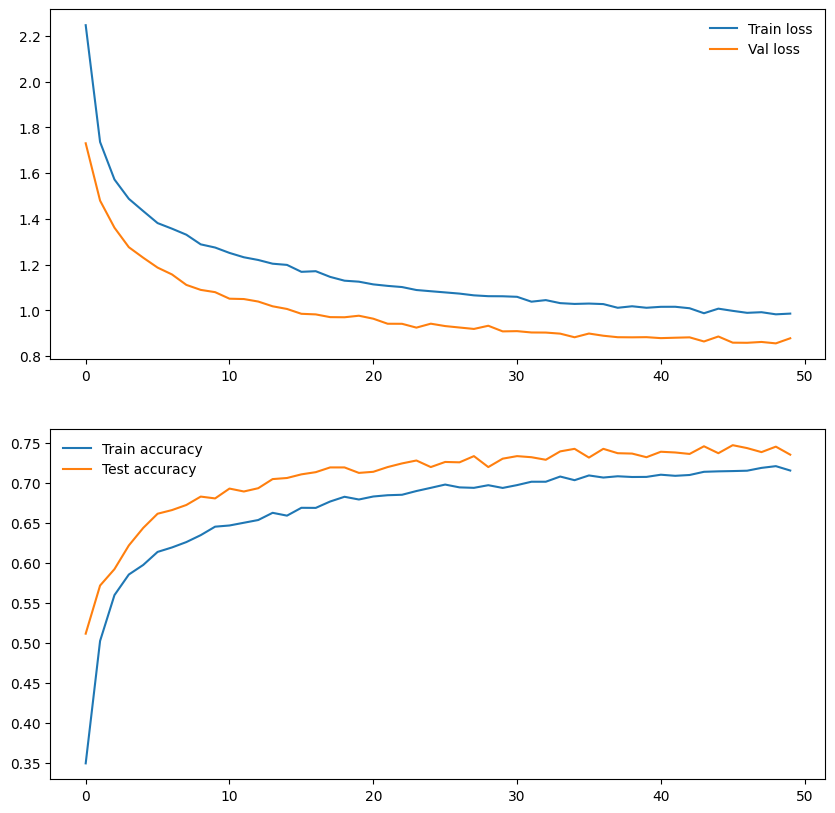

In [ ]:
train_test_info(history)

total accuracy: 0.735


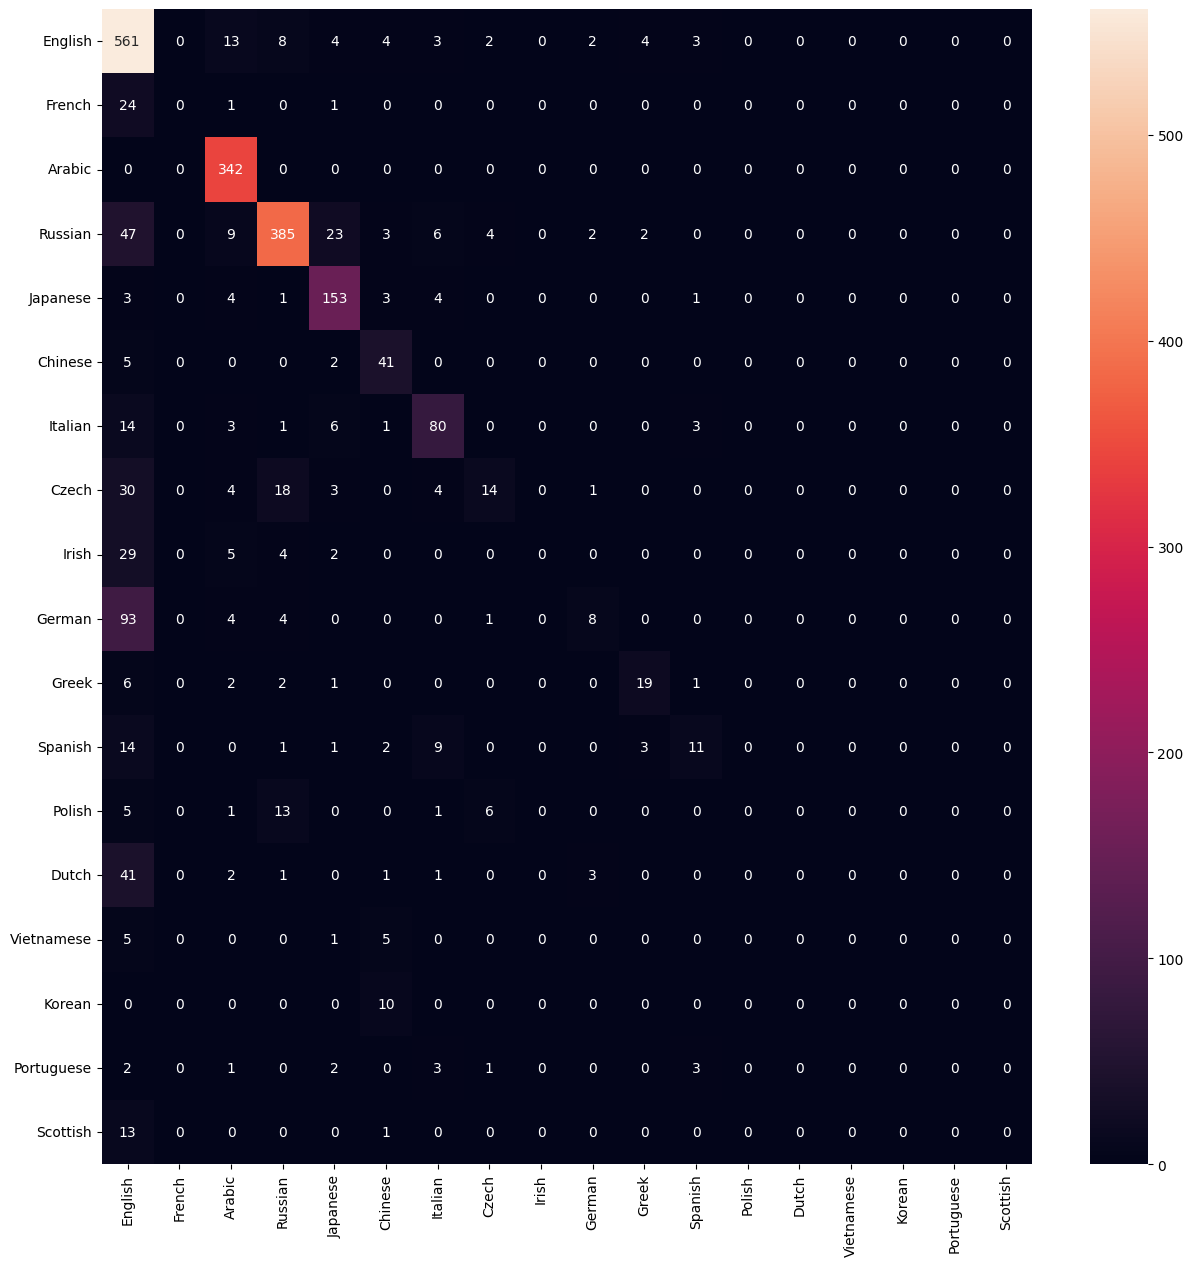

In [ ]:
conf_mat(model, testloader, classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, model, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Vaisberg 	 PREDICTED: ['English', 'German', 'Dutch']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Czech', 'Spanish', 'Russian']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'English']


#### 1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

##### Классы и функции, используемые в решении задачи

In [ ]:
class AutoModelClassifier(nn.Module):
    def __init__(self, model_name, num_embeddings, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.model_ = eval(model_name)(embedding_dim, hidden_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(hidden_size, num_classes))
        self.dropout = nn.Dropout()


    def forward(self, x):
        x = self.embedding(x)
        x = self.model_(x)
        x = x[1][0].squeeze(0) if type(x[1]) == tuple else x[1].squeeze(0)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


In [ ]:
def auto_model_training(model_name, vocab, trainloader, testloader, classes, embedding_dim=128, hidden_size=64, opt=None, crit=None, epoches=50, weights=None):
  model_ = AutoModelClassifier(
      model_name=model_name,
      num_embeddings=vocab.vocab_len,
      embedding_dim=embedding_dim,
      hidden_size=hidden_size,
      num_classes=len(classes)
  ).to(device)

  if weights != None:
     for token, value in weights.items():
      try:
          model_.embedding.weight[vocab.token_to_idx[token]] = value
      except Exception:
          pass
  for param in model_.parameters():
    param.requires_grad = True

  optimizer = torch.optim.Adam(model_.parameters(), weight_decay=0.01) if opt == None else opt
  criterion = torch.nn.CrossEntropyLoss() if crit == None else crit

  print("ОБУЧЕНИЕ МОДЕЛИ.....")
  model_, history = train_test(trainloader, testloader, model_, criterion, optimizer, epoches)
  print("\n\nГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....")
  train_test_info(history)
  print("\n\nОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....")
  conf_mat(model_, testloader, classes)
  return model_, history

##### nn.RNN

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 1.993439
test: accuracy: 52.0%, val loss: 1.719885 

Epoch 5:
train loss: 1.356645
test: accuracy: 64.9%, val loss: 1.220161 

Epoch 10:
train loss: 1.180614
test: accuracy: 69.8%, val loss: 1.065550 

Epoch 15:
train loss: 1.074922
test: accuracy: 71.9%, val loss: 0.989167 

Epoch 20:
train loss: 1.029649
test: accuracy: 72.5%, val loss: 0.951796 

Epoch 25:
train loss: 1.501265
test: accuracy: 72.5%, val loss: 0.932352 

Epoch 30:
train loss: 1.132171
test: accuracy: 73.9%, val loss: 0.903992 

Epoch 35:
train loss: 1.052314
test: accuracy: 73.1%, val loss: 0.910989 

Epoch 40:
train loss: 0.889143
test: accuracy: 73.7%, val loss: 0.871946 

Epoch 45:
train loss: 0.779689
test: accuracy: 74.1%, val loss: 0.868267 

Epoch 50:
train loss: 0.911292
test: accuracy: 74.4%, val loss: 0.860048 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


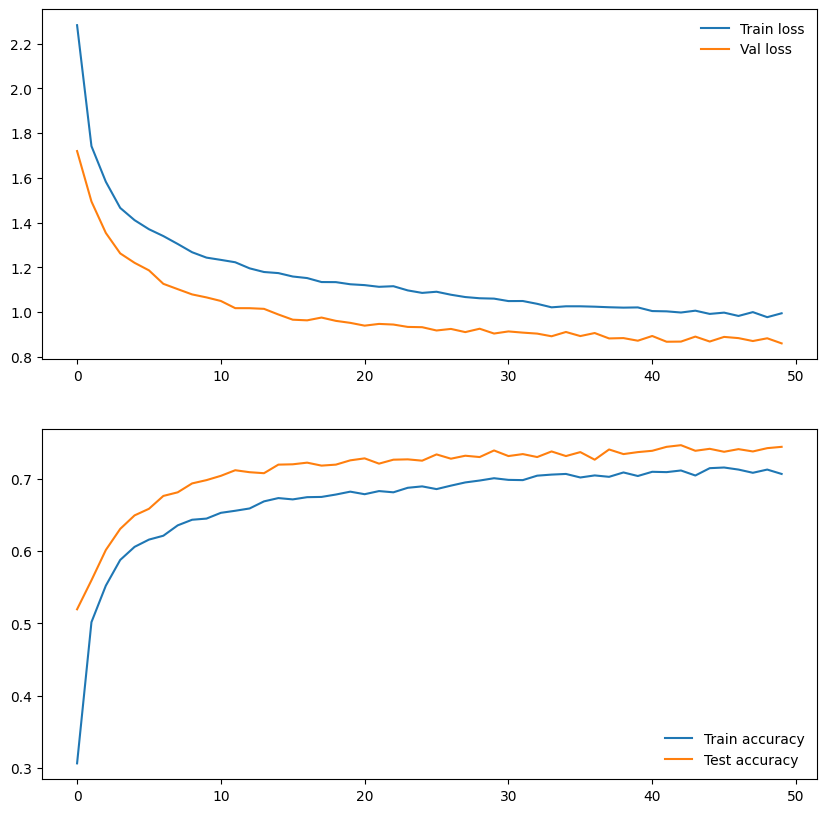



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.744


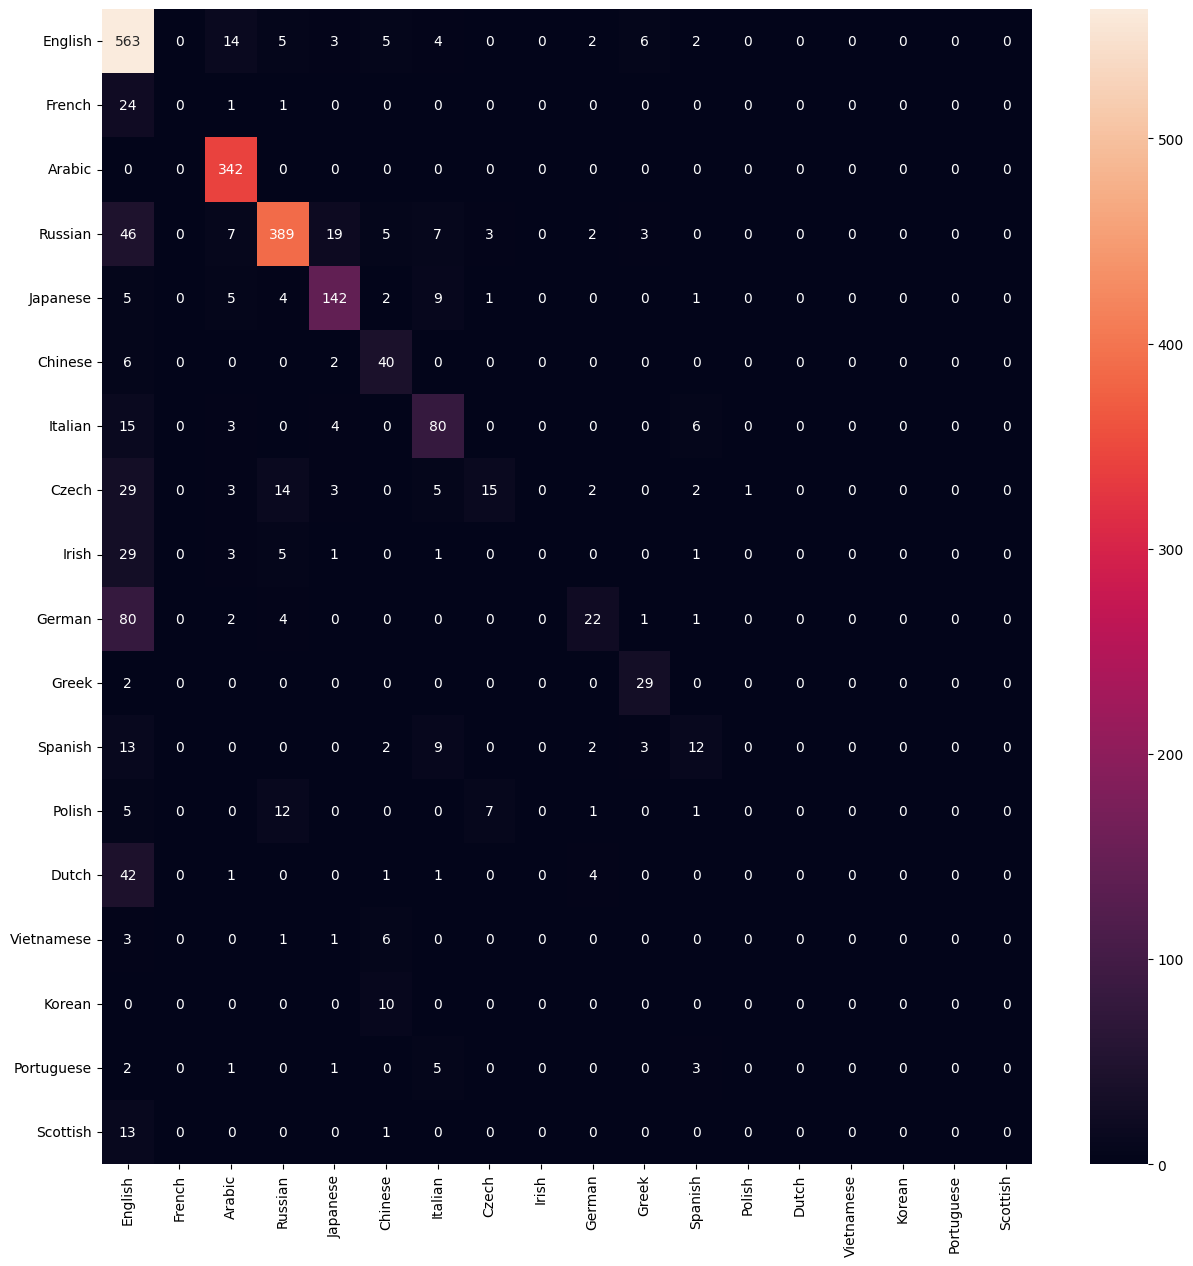

In [ ]:
RNNmodel, RNNhistory = auto_model_training(model_name="nn.RNN", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, RNNmodel, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Polish', 'Czech']
  Vaisberg 	 PREDICTED: ['English', 'German', 'Russian']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'English']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Czech', 'Russian', 'Polish']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'Polish']


##### nn.LSTM

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 1.885914
test: accuracy: 49.9%, val loss: 1.775858 

Epoch 5:
train loss: 1.292082
test: accuracy: 66.4%, val loss: 1.190036 

Epoch 10:
train loss: 1.279033
test: accuracy: 70.5%, val loss: 1.005962 

Epoch 15:
train loss: 1.120501
test: accuracy: 73.7%, val loss: 0.913811 

Epoch 20:
train loss: 1.282555
test: accuracy: 74.3%, val loss: 0.874785 

Epoch 25:
train loss: 1.036577
test: accuracy: 74.9%, val loss: 0.840307 

Epoch 30:
train loss: 0.797169
test: accuracy: 75.3%, val loss: 0.831024 

Epoch 35:
train loss: 0.924881
test: accuracy: 75.8%, val loss: 0.812024 

Epoch 40:
train loss: 0.886723
test: accuracy: 75.5%, val loss: 0.818133 

Epoch 45:
train loss: 0.896541
test: accuracy: 75.9%, val loss: 0.810261 

Epoch 50:
train loss: 0.913401
test: accuracy: 76.0%, val loss: 0.804240 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


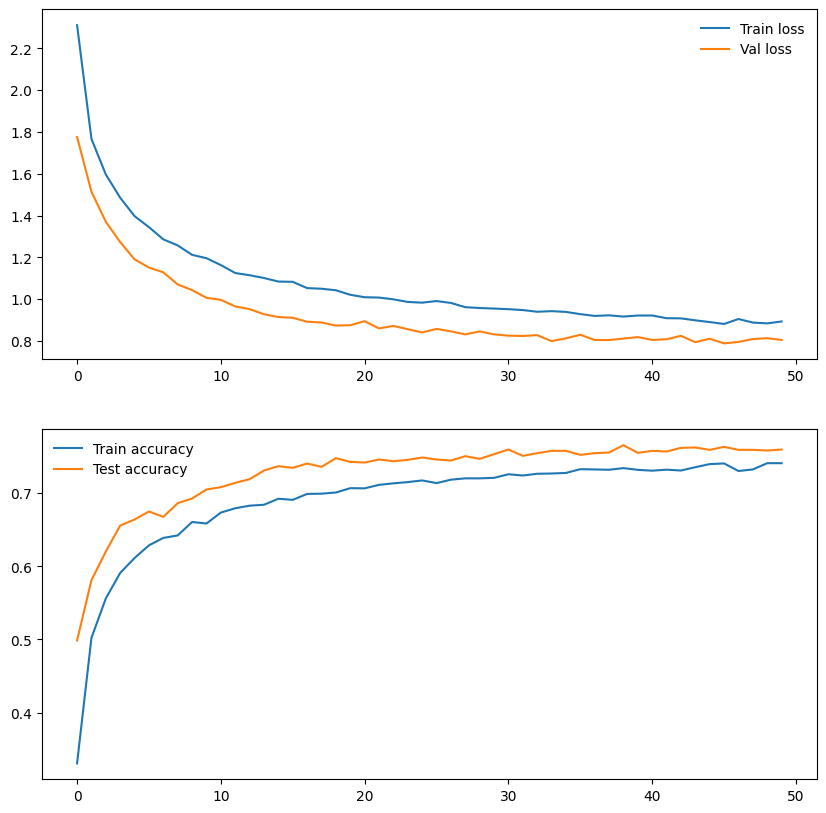



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.760


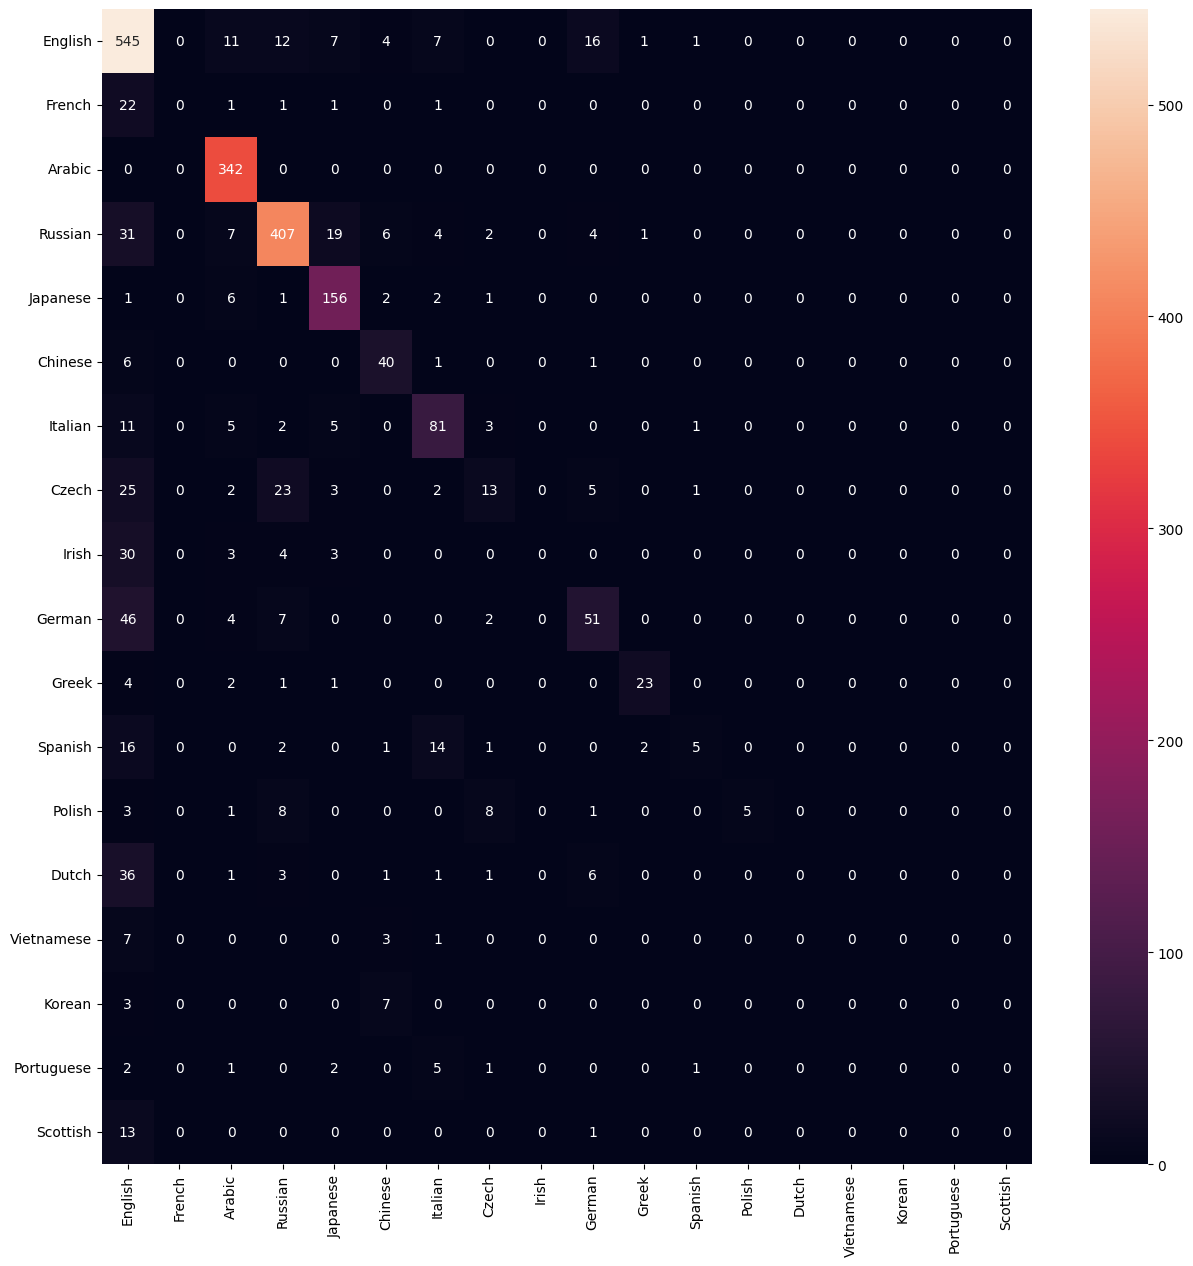

In [ ]:
LSTMmodel, LSTMhistory = auto_model_training(model_name="nn.LSTM", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, LSTMmodel, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Polish', 'Czech']
  Vaisberg 	 PREDICTED: ['English', 'German', 'Russian']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'Irish']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Russian', 'Czech', 'Polish']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'English']


##### nn.GRU

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 2.042416
test: accuracy: 51.1%, val loss: 1.753340 

Epoch 5:
train loss: 1.483043
test: accuracy: 67.2%, val loss: 1.173611 

Epoch 10:
train loss: 1.166648
test: accuracy: 71.1%, val loss: 1.000146 

Epoch 15:
train loss: 1.080067
test: accuracy: 72.4%, val loss: 0.921005 

Epoch 20:
train loss: 1.174289
test: accuracy: 74.4%, val loss: 0.860194 

Epoch 25:
train loss: 1.017959
test: accuracy: 75.0%, val loss: 0.860612 

Epoch 30:
train loss: 0.689973
test: accuracy: 76.1%, val loss: 0.816991 

Epoch 35:
train loss: 1.121012
test: accuracy: 76.6%, val loss: 0.792730 

Epoch 40:
train loss: 0.937658
test: accuracy: 76.6%, val loss: 0.797968 

Epoch 45:
train loss: 0.866368
test: accuracy: 76.8%, val loss: 0.799977 

Epoch 50:
train loss: 0.834484
test: accuracy: 77.2%, val loss: 0.782509 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


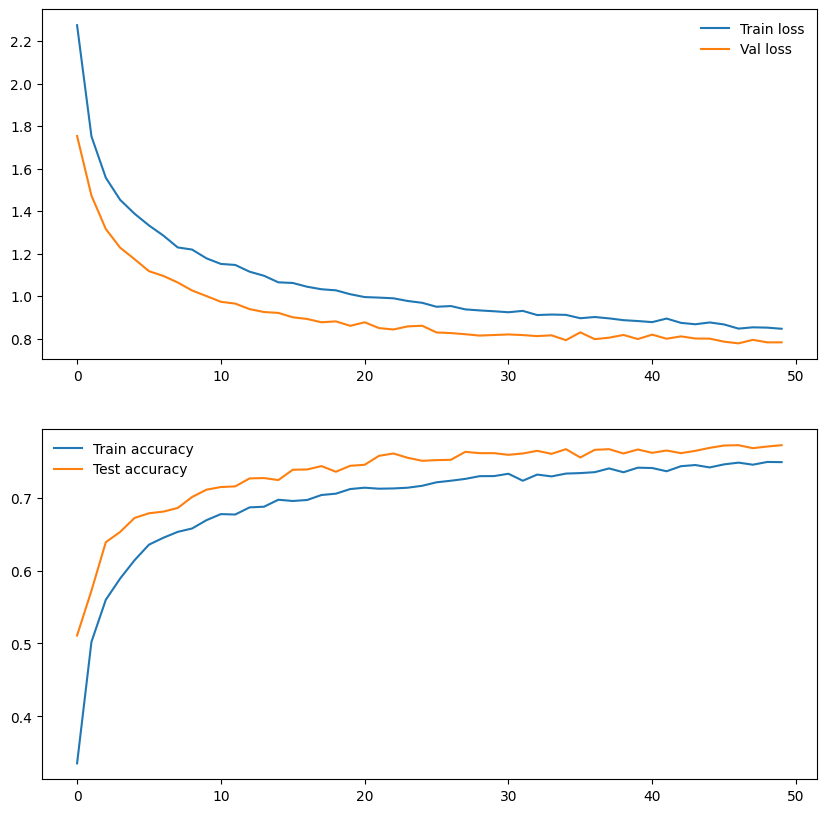



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.772


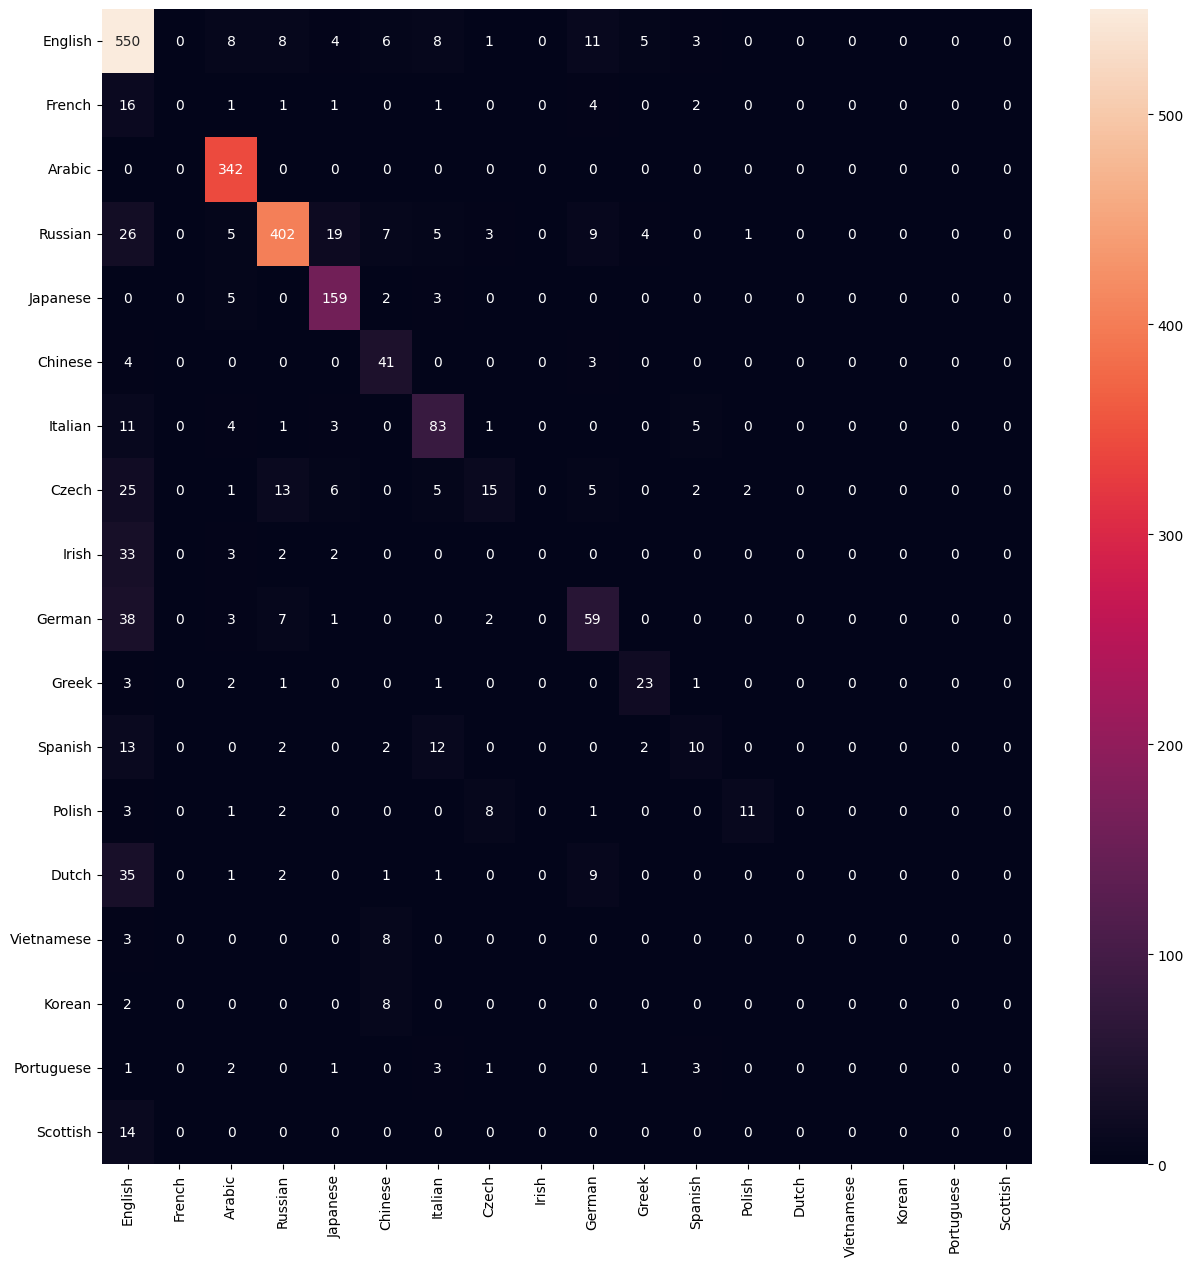

In [ ]:
GRUmodel, GRUhistory = auto_model_training(model_name="nn.GRU", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, GRUmodel, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Vaisberg 	 PREDICTED: ['German', 'English', 'Dutch']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'German']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Czech', 'Russian', 'Spanish']
   Ishmaev 	 PREDICTED: ['Russian', 'German', 'Czech']


##### Сравнение результатов работы:

In [ ]:
print(f"{'Модель':>8}{'Точность':>10}")
for name, hist in dict(zip(["RNN", "nn.RNN", "nn.LSTM", "nn.GRU"], [history, RNNhistory, LSTMhistory, GRUhistory])).items():
  print(f'{name:>8}{list(hist["test accuracy"])[-1]:>8.3f}')

  Модель  Точность
     RNN   0.735
  nn.RNN   0.744
 nn.LSTM   0.760
  nn.GRU   0.772


#### 1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [ ]:
with open('globe_100_rows.txt') as file:
    weights = file.readlines()
    weights = list(map(str.split, weights))
    weights = {i[0]: torch.tensor(list(map(float, i[1:]))) for i in weights}

##### nn.RNN (embedded)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 1.748450
test: accuracy: 51.7%, val loss: 1.753256 

Epoch 5:
train loss: 1.723436
test: accuracy: 64.5%, val loss: 1.251175 

Epoch 10:
train loss: 1.370176
test: accuracy: 67.6%, val loss: 1.097017 

Epoch 15:
train loss: 1.159891
test: accuracy: 71.3%, val loss: 1.010722 

Epoch 20:
train loss: 0.907502
test: accuracy: 70.9%, val loss: 0.991443 

Epoch 25:
train loss: 1.256790
test: accuracy: 71.4%, val loss: 0.964579 

Epoch 30:
train loss: 1.032298
test: accuracy: 73.5%, val loss: 0.914531 

Epoch 35:
train loss: 0.883096
test: accuracy: 73.8%, val loss: 0.895626 

Epoch 40:
train loss: 1.144641
test: accuracy: 74.1%, val loss: 0.878018 

Epoch 45:
train loss: 0.926146
test: accuracy: 73.2%, val loss: 0.900766 

Epoch 50:
train loss: 1.087560
test: accuracy: 74.9%, val loss: 0.877684 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


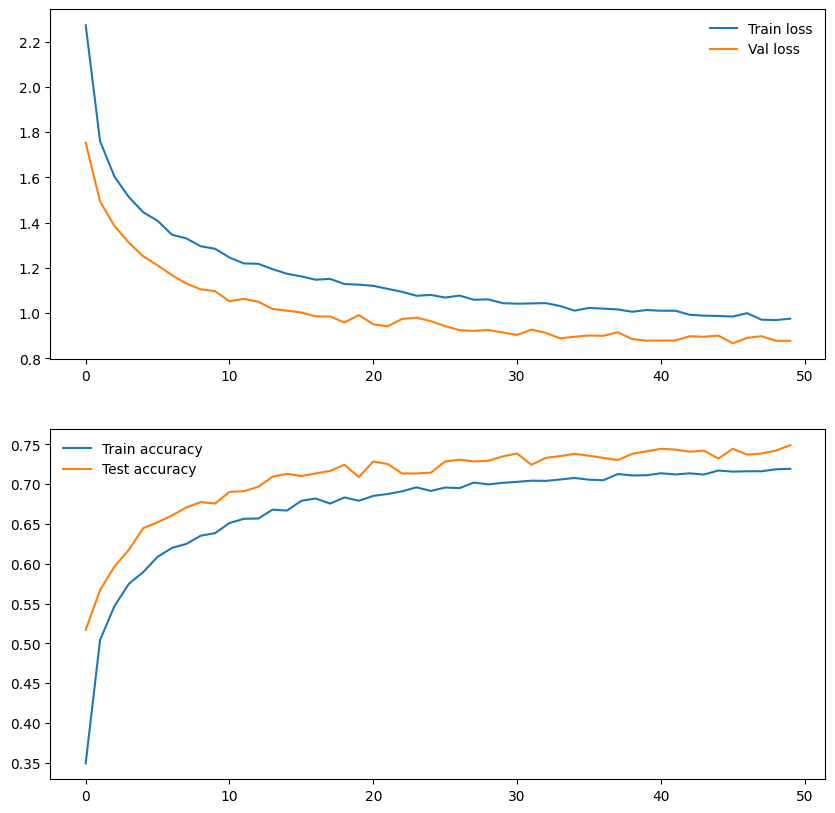



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.749


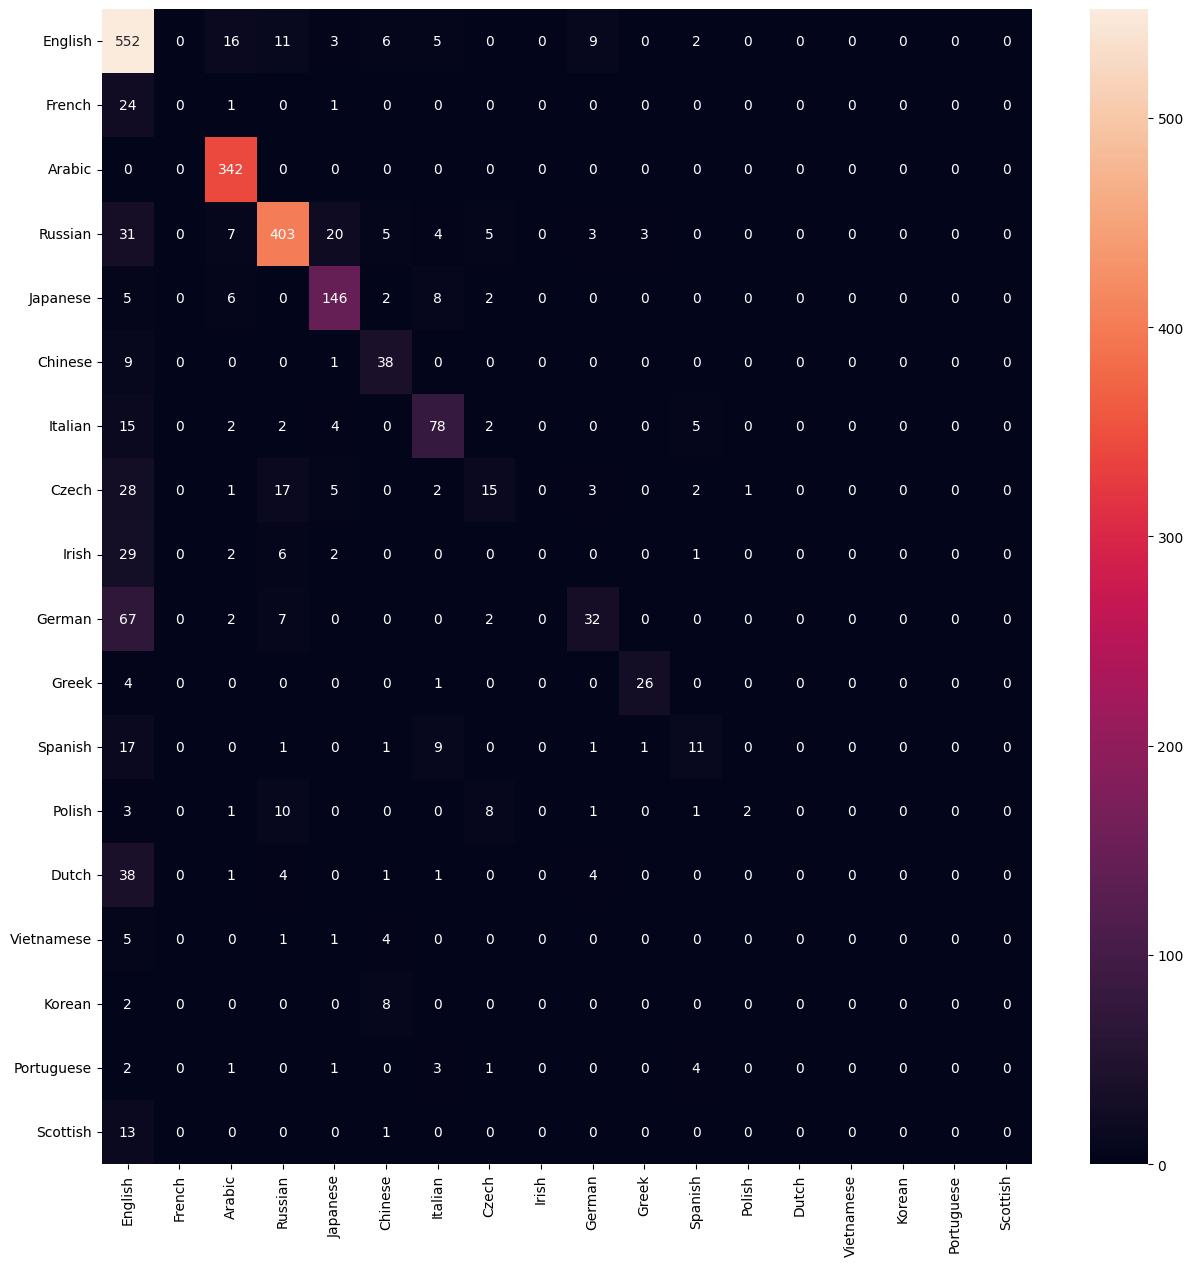

In [ ]:
RNNmodel_emb, RNNhistory_emb = auto_model_training(model_name="nn.RNN", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes, weights=weights)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, RNNmodel_emb, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Vaisberg 	 PREDICTED: ['Russian', 'German', 'Czech']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'Irish']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Czech', 'Russian', 'Polish']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'German']


##### nn.LSTM (embedded)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 1.627863
test: accuracy: 48.1%, val loss: 1.773695 

Epoch 5:
train loss: 1.350098
test: accuracy: 64.7%, val loss: 1.211318 

Epoch 10:
train loss: 1.358524
test: accuracy: 71.0%, val loss: 1.013102 

Epoch 15:
train loss: 1.034690
test: accuracy: 72.8%, val loss: 0.945704 

Epoch 20:
train loss: 1.051924
test: accuracy: 74.4%, val loss: 0.897111 

Epoch 25:
train loss: 0.811556
test: accuracy: 73.9%, val loss: 0.865516 

Epoch 30:
train loss: 0.744600
test: accuracy: 75.1%, val loss: 0.859615 

Epoch 35:
train loss: 0.941548
test: accuracy: 75.9%, val loss: 0.824911 

Epoch 40:
train loss: 1.091581
test: accuracy: 75.7%, val loss: 0.823300 

Epoch 45:
train loss: 0.819184
test: accuracy: 76.0%, val loss: 0.812702 

Epoch 50:
train loss: 1.160471
test: accuracy: 76.4%, val loss: 0.818300 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


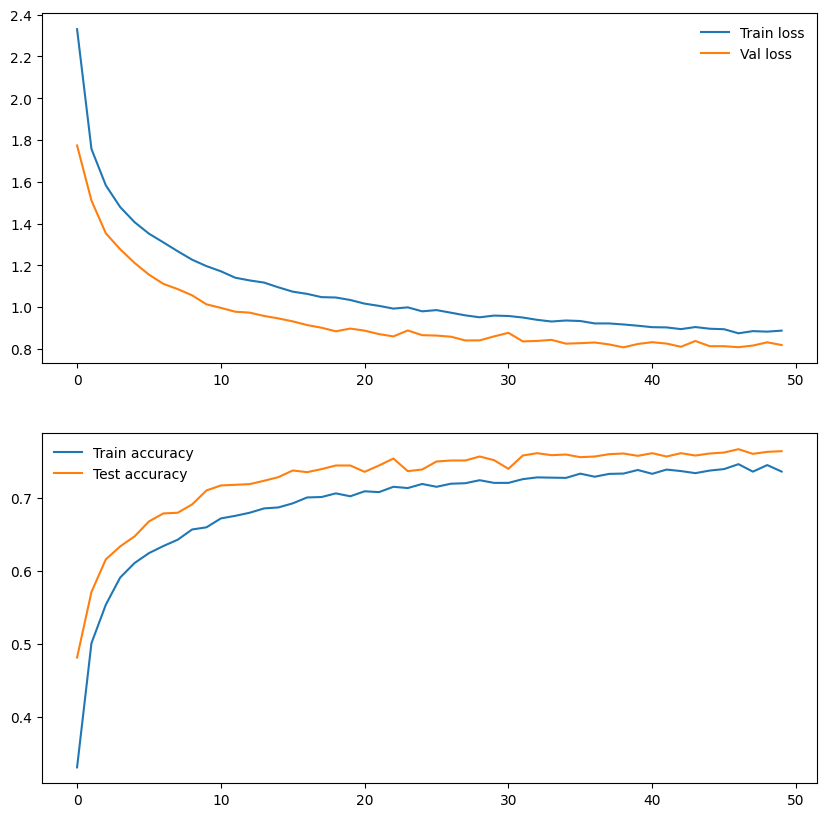



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.764


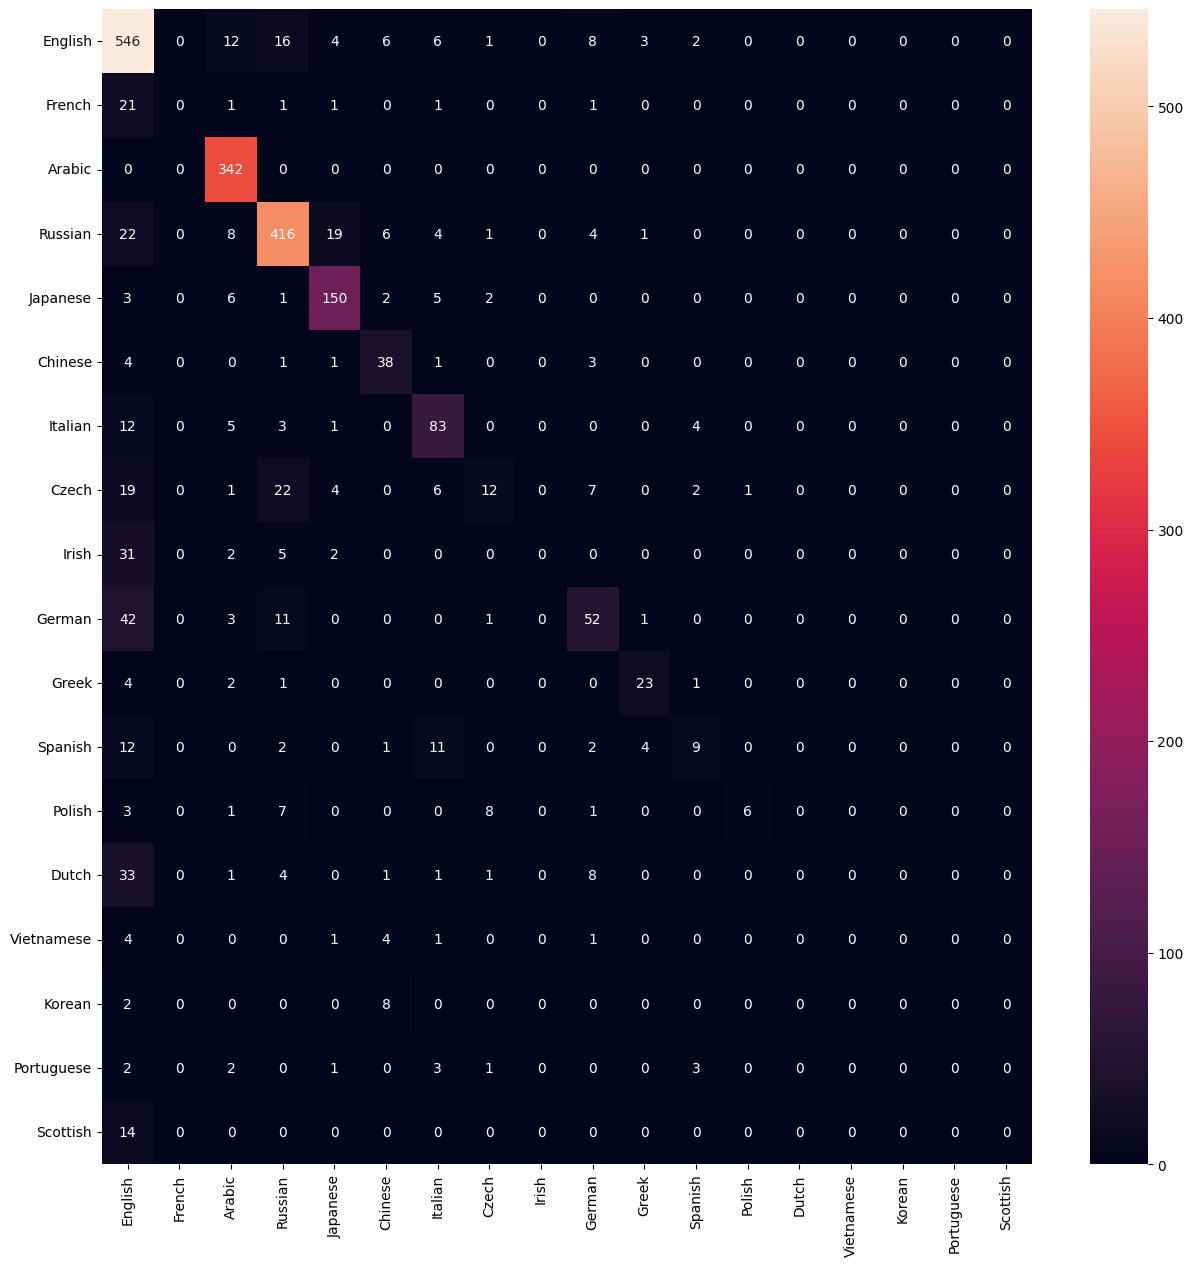

In [ ]:
LSTMmodel_emb, LSTMhistory_emb = auto_model_training(model_name="nn.LSTM", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes, weights=weights)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, LSTMmodel_emb, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Vaisberg 	 PREDICTED: ['Russian', 'German', 'Czech']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Russian', 'Czech', 'Spanish']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'German']


##### nn.GRU (embedded)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 1.858210
test: accuracy: 51.8%, val loss: 1.748112 

Epoch 5:
train loss: 1.459856
test: accuracy: 66.5%, val loss: 1.172524 

Epoch 10:
train loss: 0.963544
test: accuracy: 71.0%, val loss: 0.997996 

Epoch 15:
train loss: 1.106114
test: accuracy: 73.1%, val loss: 0.917321 

Epoch 20:
train loss: 1.058335
test: accuracy: 75.2%, val loss: 0.862902 

Epoch 25:
train loss: 0.841822
test: accuracy: 74.1%, val loss: 0.868991 

Epoch 30:
train loss: 0.908290
test: accuracy: 75.3%, val loss: 0.836477 

Epoch 35:
train loss: 0.957790
test: accuracy: 75.8%, val loss: 0.835361 

Epoch 40:
train loss: 0.918112
test: accuracy: 76.1%, val loss: 0.797526 

Epoch 45:
train loss: 0.916761
test: accuracy: 76.3%, val loss: 0.798596 

Epoch 50:
train loss: 1.004447
test: accuracy: 76.6%, val loss: 0.794926 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


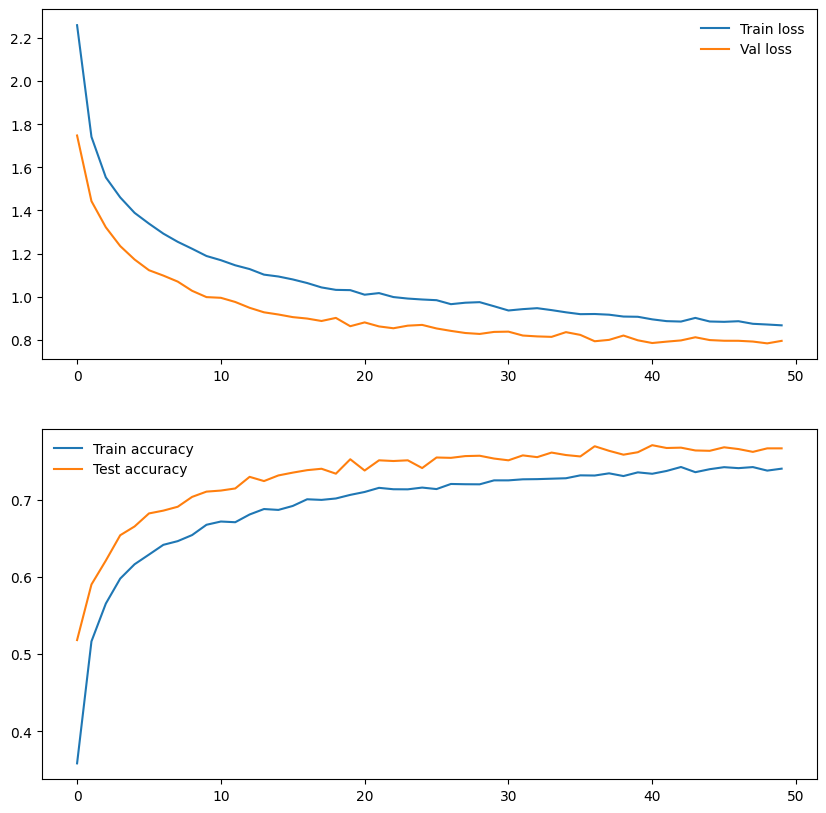



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.766


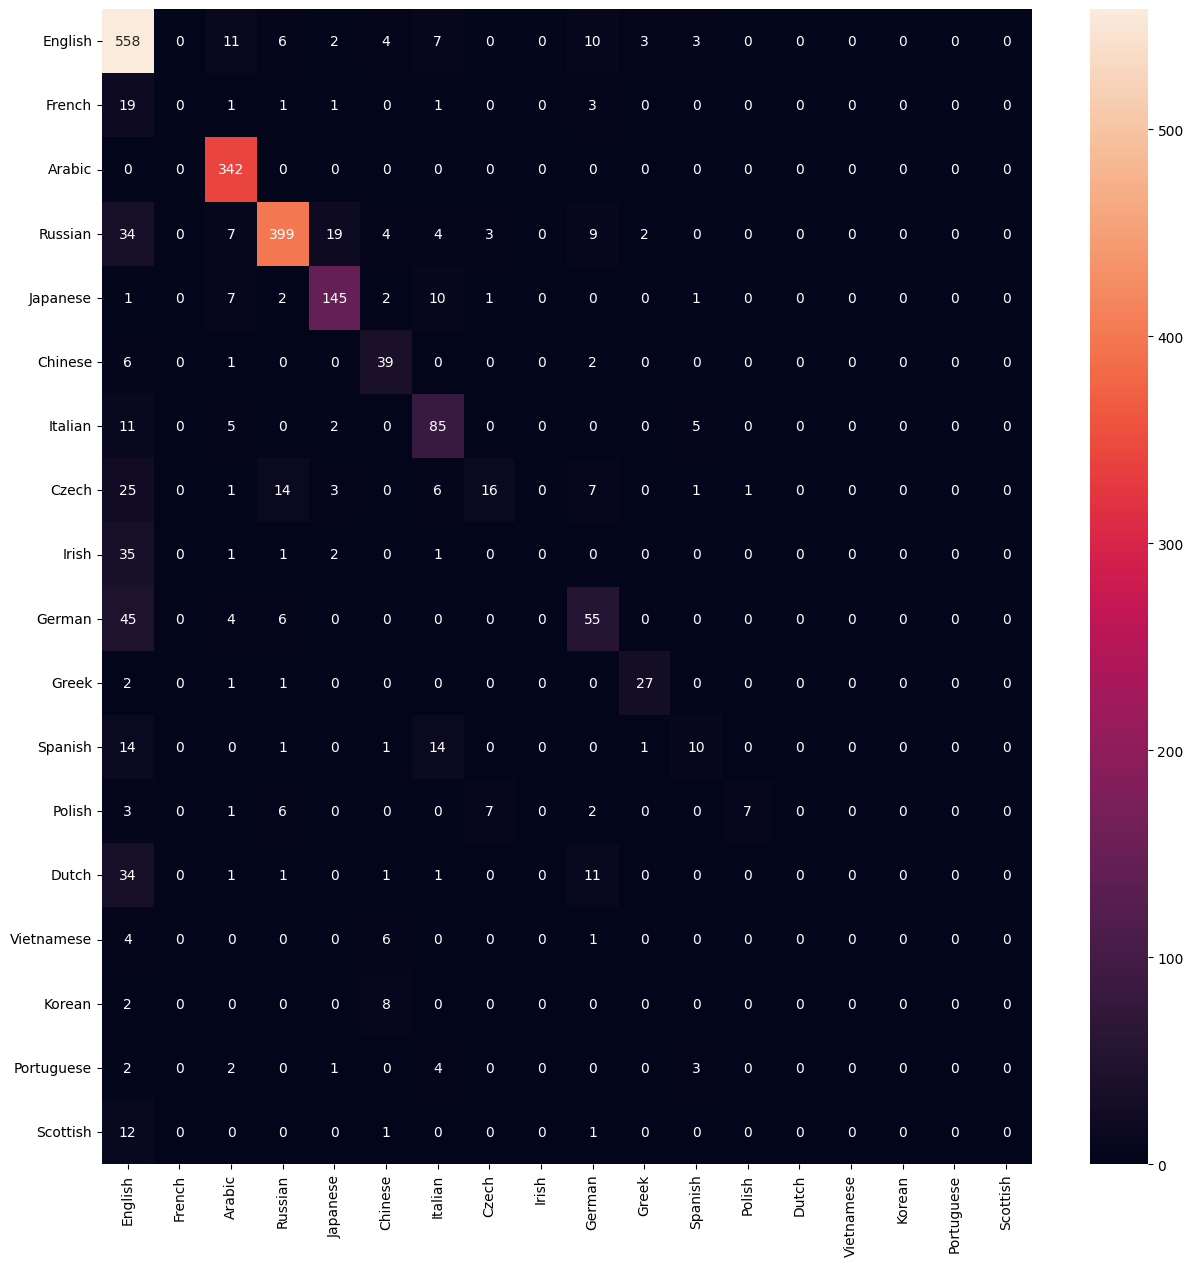

In [ ]:
GRUmodel_emb, GRUhistory_emb = auto_model_training(model_name="nn.GRU", vocab=vocab, trainloader=trainloader, testloader=testloader, classes=classes, weights=weights)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, GRUmodel_emb, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Vaisberg 	 PREDICTED: ['German', 'English', 'Dutch']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'English']
  Hirasawa 	 PREDICTED: ['Japanese', 'Russian', 'Czech']
   Aluyeva 	 PREDICTED: ['Czech', 'Spanish', 'Italian']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'German']


##### Сравнение точности моделей без и с предобученным эмбеддингом

In [ ]:
print(f"{'Модель':>8}{'Точность до эмбеддинга':>30}{'Точность после эмбеддинга':>30}")
for name, hist in dict(zip(["nn.RNN", "nn.LSTM", "nn.GRU"], [(RNNhistory, RNNhistory_emb), (LSTMhistory, LSTMhistory_emb), (GRUhistory, GRUhistory_emb)])).items():
  print(f'{name:>8}{list(hist[0]["test accuracy"])[-1]:^30.3f}{list(hist[1]["test accuracy"])[-1]:^30.3f}')

  Модель        Точность до эмбеддинга     Точность после эмбеддинга
  nn.RNN            0.744                         0.749             
 nn.LSTM            0.760                         0.764             
  nn.GRU            0.772                         0.766             


## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/polarity.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 3/3 [00:00<00:00, 97.46it/s]


In [ ]:
with open('/content/polarity/positive_reviews.txt') as file:
    positive_reviews = file.readlines()

with open('/content/polarity/negative_reviews.txt') as file:
    negative_reviews = file.readlines()

positive_reviews = pd.DataFrame(positive_reviews, columns=['review'])
positive_reviews['rating'] = 1
negative_reviews = pd.DataFrame(negative_reviews, columns=['review'])
negative_reviews['rating'] = 0

reviews = pd.concat([positive_reviews, negative_reviews])
reviews.sample(5, random_state=20)

,review,rating
4597,you can fire a torpedo through some of clancy'...,0
4119,worth seeing just for weaver and lapaglia .\n,0
2674,reign of fire just might go down as one of the...,0
452,disturbing and brilliant documentary .\n,0
4537,shows moments of promise but ultimately succum...,1


In [ ]:
train_reviews, test_reviews = train_test_split(reviews, test_size=0.2)
train_reviews.head()

,review,rating
3244,"all three actresses are simply dazzling , part...",0
1858,"manages to be somewhat well-acted , not badly ...",1
1941,serving sara doesn't serve up a whole lot of l...,1
1135,a must-see for the david mamet enthusiast and ...,0
2527,a diverse and astonishingly articulate cast of...,0


In [ ]:
class Vocab:
    def __init__(self, data, unk_token: str = "<UNK>"):
        self.max_seq_len = 0
        tokens = set()
        for item in data:
            words = [word for word in word_tokenize(self.preprocess_text(item))]
            if len(words) > self.max_seq_len:
                self.max_seq_len = len(words)
            tokens.update(words)
        if unk_token is not None:
            tokens.add(unk_token)
        self.idx_to_token = dict(enumerate(tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

    def preprocess_text(self, text):
        return re.sub(r"[^a-zA-Z,!?\.]", " ", text.lower())

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def to_indices(self, review):
        seq = [
            self.vocab.token_to_idx[token]
            if token in self.vocab.token_to_idx.keys()
            else self.vocab.token_to_idx["<PAD>"]
            for token in word_tokenize(review)
        ]
        if len(seq) < self.vocab.max_seq_len:
            seq.extend([self.vocab.token_to_idx["<PAD>"]] * (self.vocab.max_seq_len - len(seq)))
        else:
            seq = seq[: self.vocab.max_seq_len]
        return torch.LongTensor(seq)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.to_indices(self.X[idx]), self.y[idx]

In [ ]:
vocab_review = Vocab(train_reviews["review"])
len(vocab_review.idx_to_token)

16372

In [ ]:
train_dataset = ReviewsDataset(train_reviews["review"].to_numpy(), train_reviews["rating"].to_numpy(), vocab_review)
test_dataset = ReviewsDataset(test_reviews["review"].to_numpy(), test_reviews["rating"].to_numpy(), vocab_review)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
print(f'dataset size: {len(train_dataset)+len(test_dataset)}\n' +
      f'train size: {len(train_dataset)}\ntest size: {len(test_dataset)}')
classes = ['positive', 'negative']

dataset size: 10662
train size: 8529
test size: 2133


ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 0.682770
test: accuracy: 51.1%, val loss: 0.693350 

Epoch 5:
train loss: 0.680129
test: accuracy: 51.1%, val loss: 0.693329 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


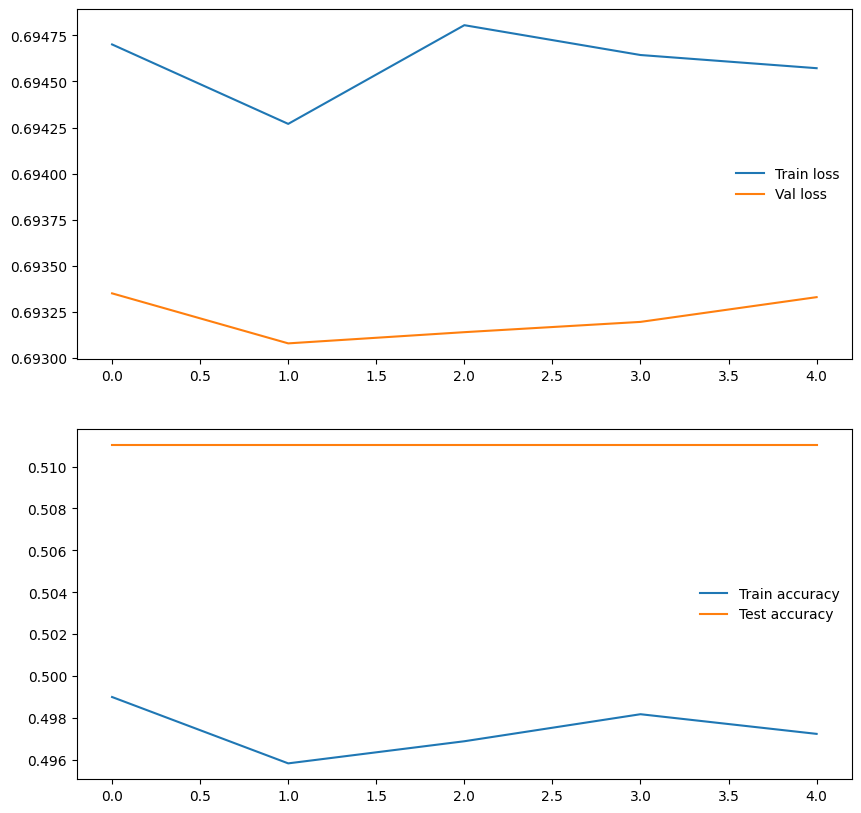



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.511


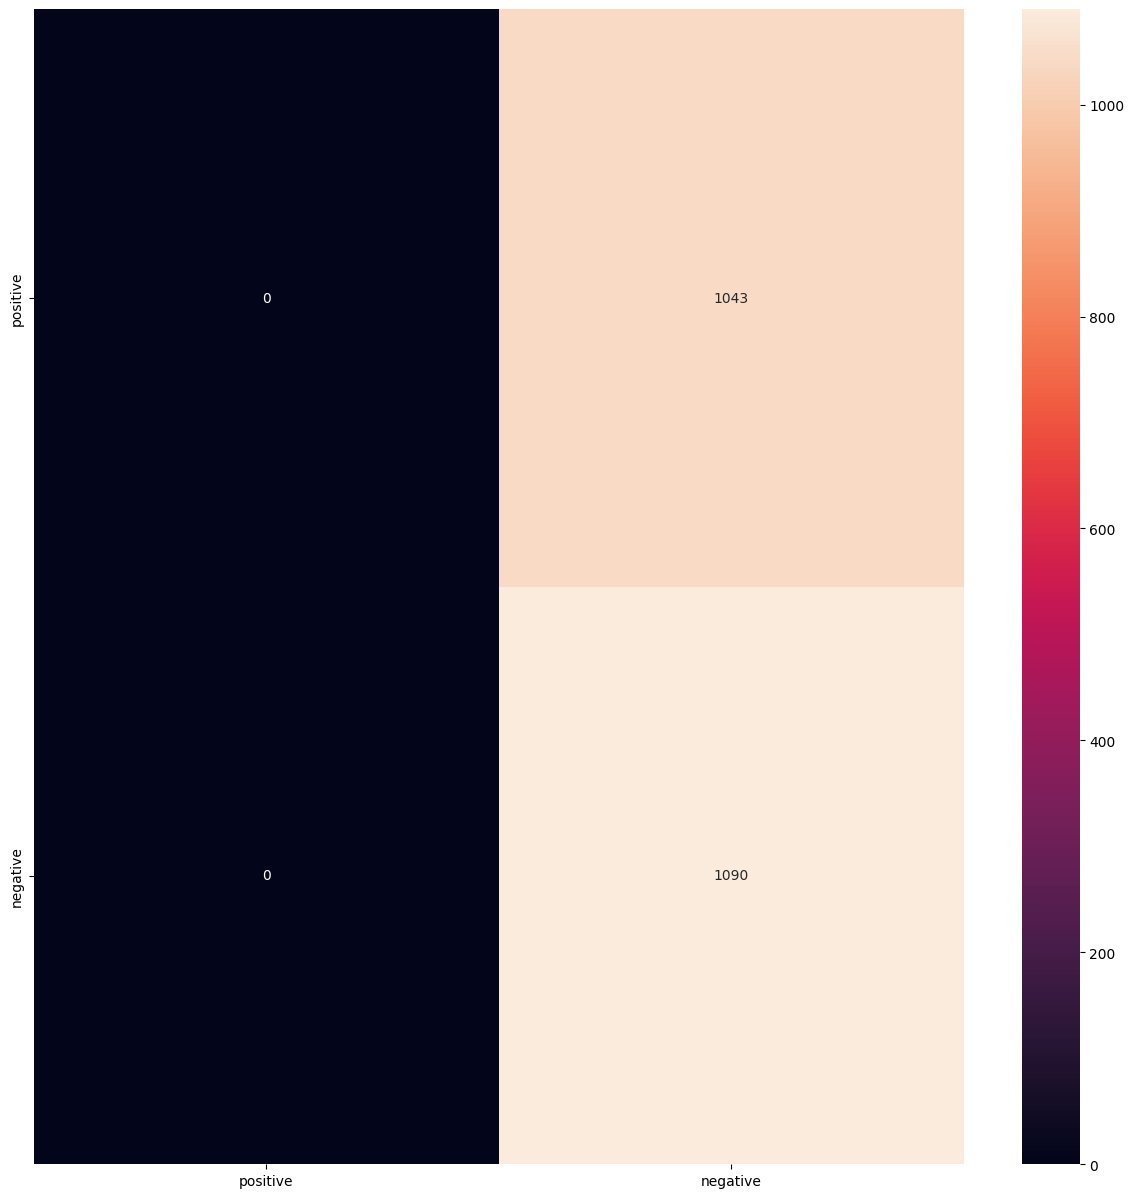

In [ ]:
rnn_model_, rnn_history_ = auto_model_training(model_name="nn.RNN", vocab=vocab_review, trainloader=trainloader, testloader=testloader, classes=classes, embedding_dim=256, hidden_size=128, epoches=5)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 0.696321
test: accuracy: 51.1%, val loss: 0.692997 

Epoch 5:
train loss: 0.693546
test: accuracy: 48.9%, val loss: 0.694025 

Epoch 10:
train loss: 0.694848
test: accuracy: 48.9%, val loss: 0.693189 

Epoch 15:
train loss: 0.692910
test: accuracy: 48.9%, val loss: 0.693215 

Epoch 20:
train loss: 0.693813
test: accuracy: 48.9%, val loss: 0.693163 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


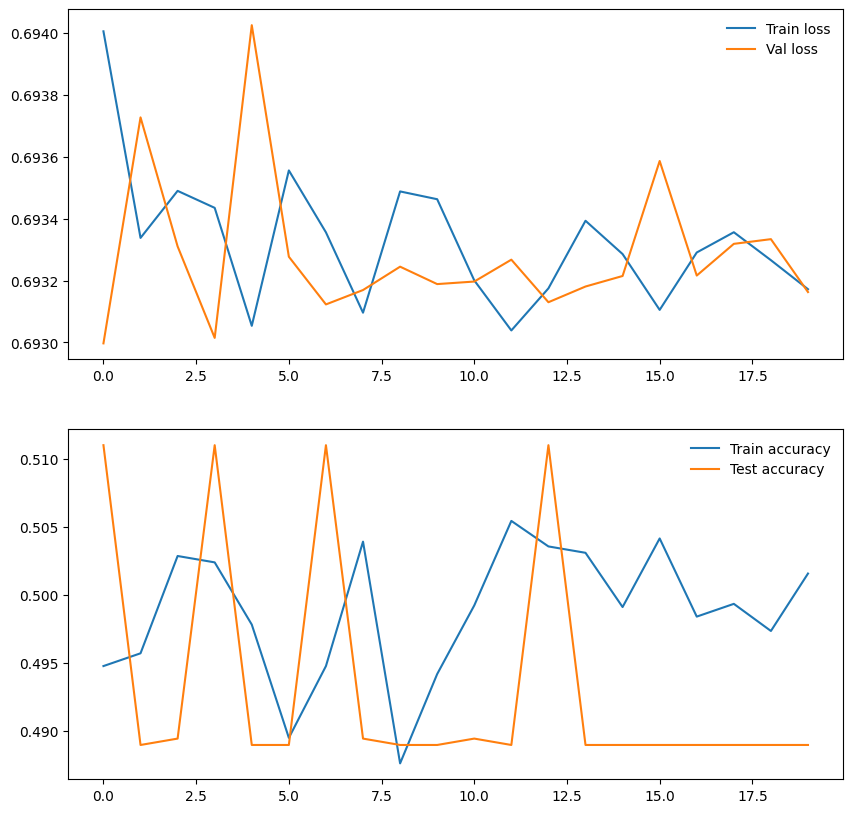



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.489


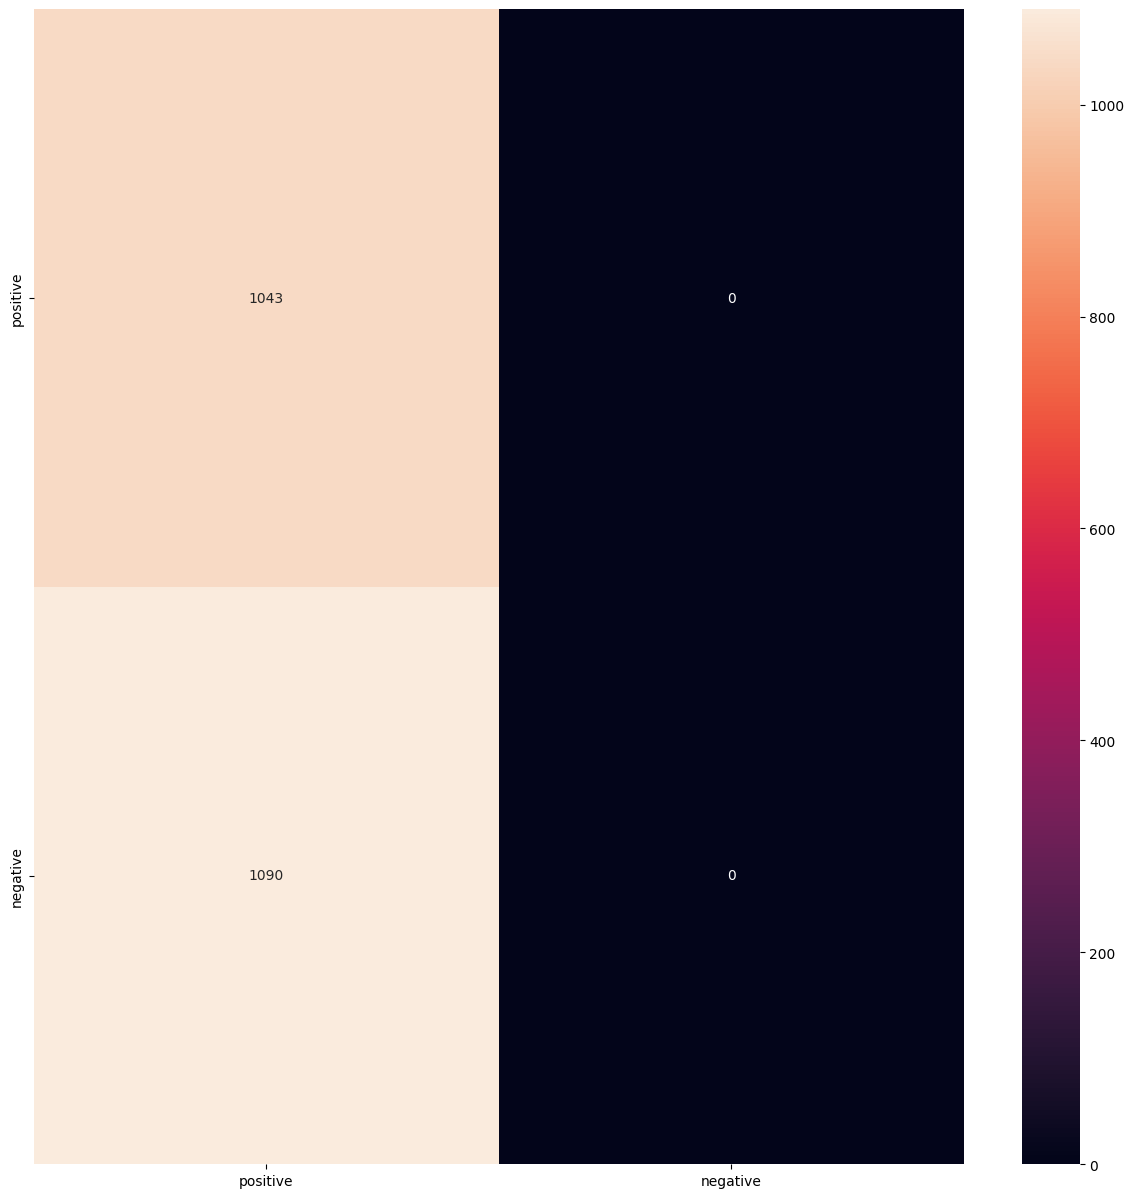

In [ ]:
rnn_model, rnn_history = auto_model_training(model_name="nn.RNN", vocab=vocab_review, trainloader=trainloader, testloader=testloader, classes=classes, embedding_dim=256, hidden_size=128, epoches=20)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 0.693780
test: accuracy: 48.9%, val loss: 0.694458 

Epoch 5:
train loss: 0.691526
test: accuracy: 48.9%, val loss: 0.693715 

Epoch 10:
train loss: 0.691623
test: accuracy: 48.9%, val loss: 0.693170 

Epoch 15:
train loss: 0.693557
test: accuracy: 48.9%, val loss: 0.693350 

Epoch 20:
train loss: 0.693181
test: accuracy: 48.9%, val loss: 0.693343 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


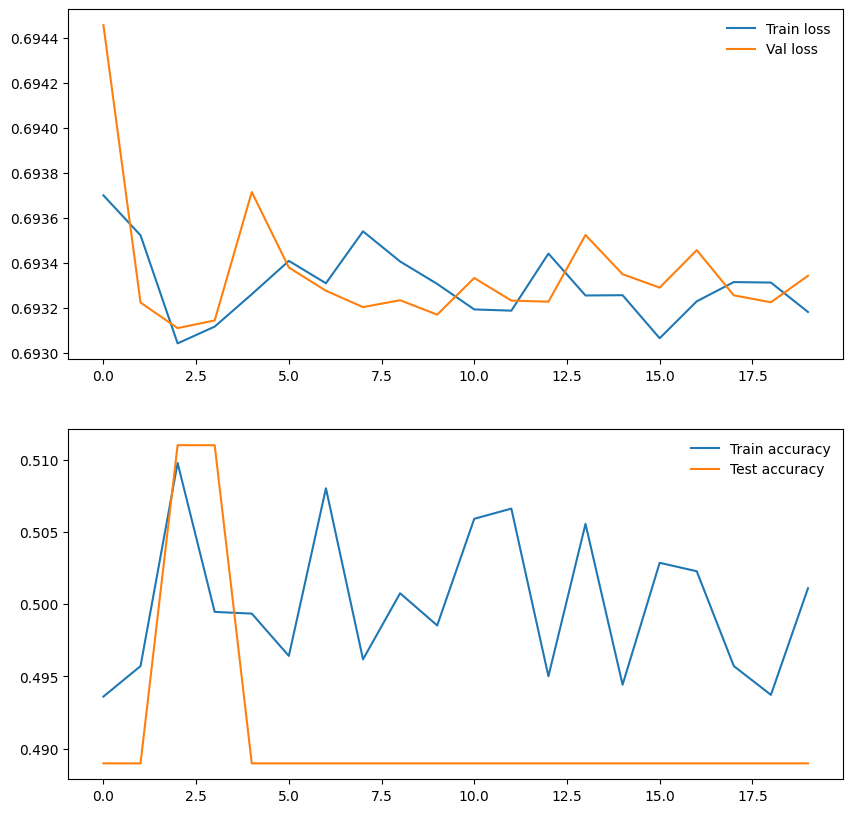



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.489


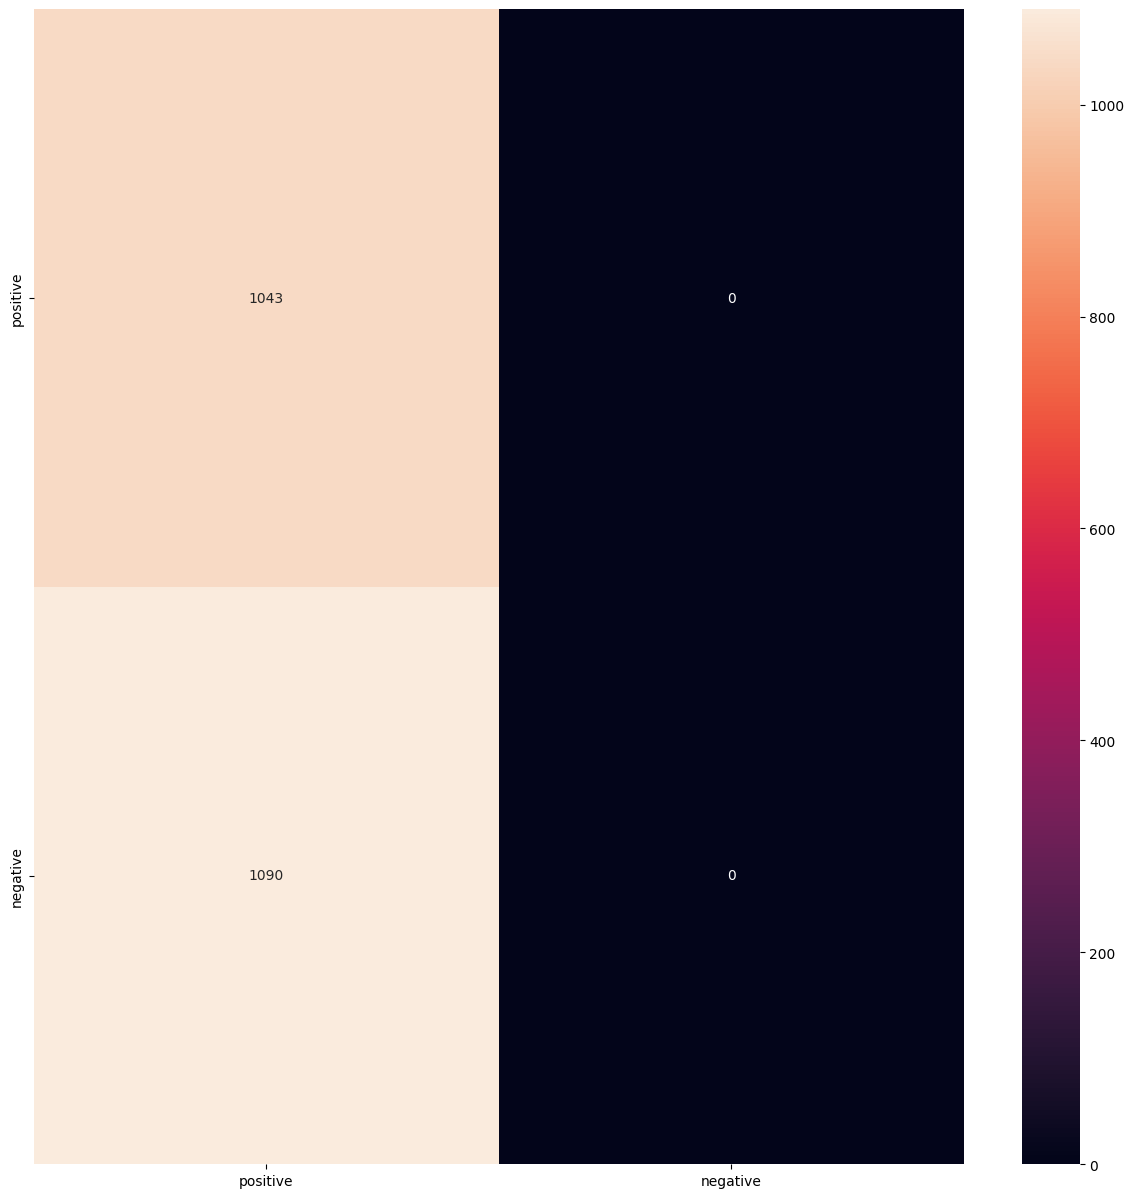

In [ ]:
lstm_model, lstm_history = auto_model_training(model_name="nn.LSTM", vocab=vocab_review, trainloader=trainloader, testloader=testloader, classes=classes, embedding_dim=256, hidden_size=128, epoches=20)

ОБУЧЕНИЕ МОДЕЛИ.....
Epoch 1:
train loss: 0.691674
test: accuracy: 51.1%, val loss: 0.692975 

Epoch 5:
train loss: 0.694312
test: accuracy: 48.9%, val loss: 0.693232 

Epoch 10:
train loss: 0.692959
test: accuracy: 48.9%, val loss: 0.693167 

Epoch 15:
train loss: 0.692004
test: accuracy: 48.9%, val loss: 0.693229 

Epoch 20:
train loss: 0.693951
test: accuracy: 48.9%, val loss: 0.693178 



ГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....


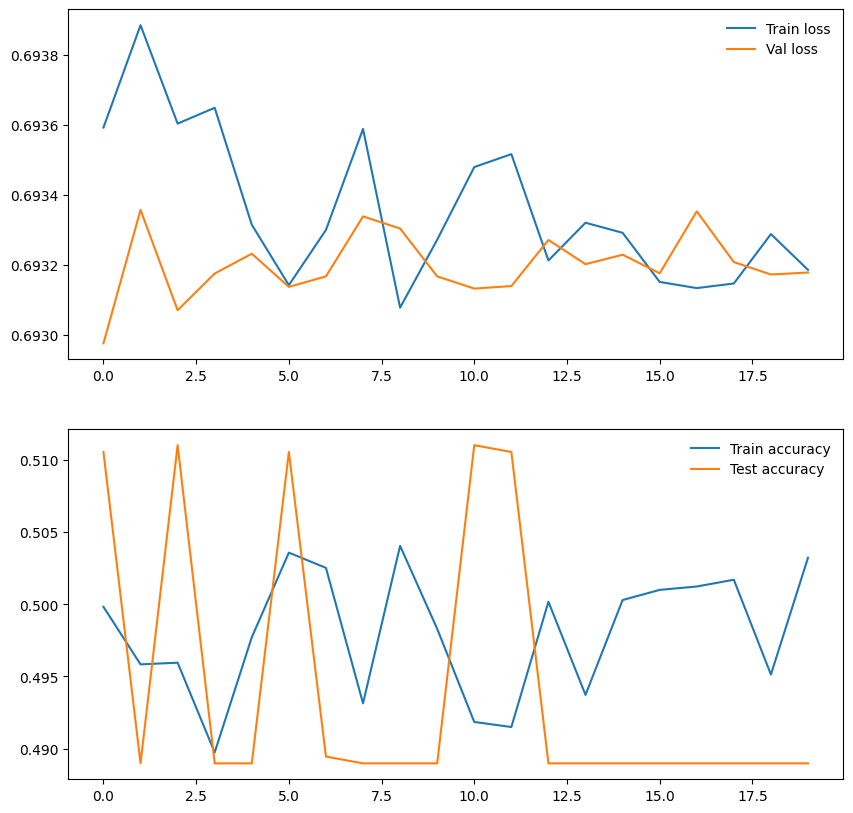



ОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....
total accuracy: 0.489


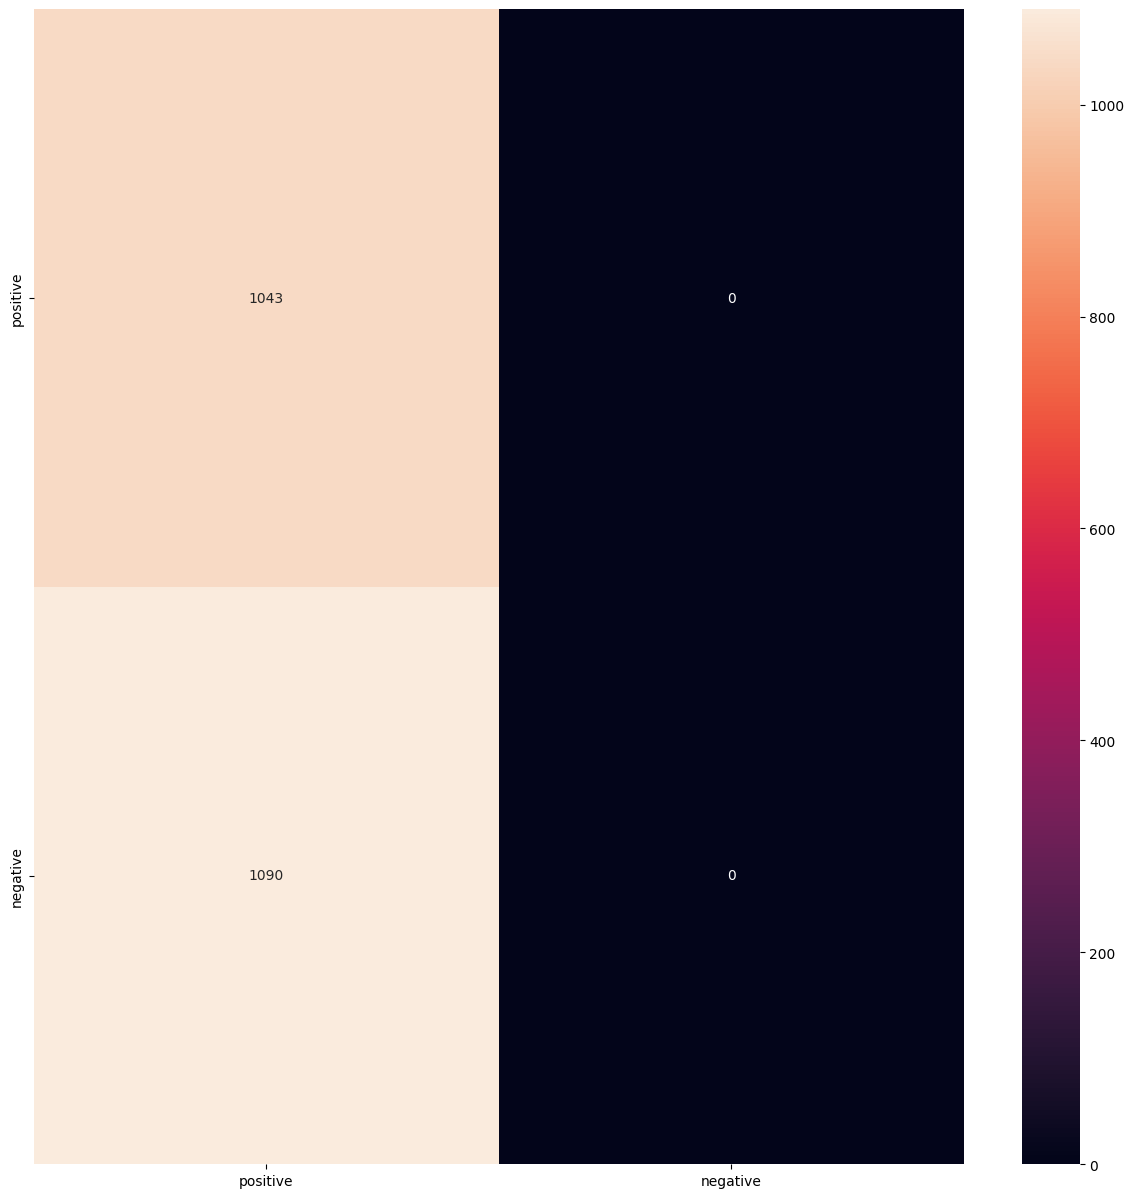

In [ ]:
gru_model, gru_history = auto_model_training(model_name="nn.GRU", vocab=vocab_review, trainloader=trainloader, testloader=testloader, classes=classes, embedding_dim=256, hidden_size=128, epoches=20)

### useless

In [ ]:
class AutoModelReviewClassifier(nn.Module):
    def __init__(self, model_name, num_embeddings, embedding_dim, hidden_size, num_classes, n_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.model_ = eval(model_name)(embedding_dim, hidden_size, num_layers=n_layers, batch_first=True)
        self.classifier = self.classifier = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = self.embedding(x)  # batch x seq x emb
        output, (x, cell) = self.model_(x)
        x = self.dropout(x.squeeze(0))
        x = self.classifier(x)  # batch x num_classes
        return x


In [ ]:
def auto_model_review_training(model_name, vocab, trainloader, testloader, classes, embedding_dim=128, hidden_size=64, n_layers=1, dropout=0.5, opt=None, crit=None, epoches=50, weights=None):
  model_ = AutoModelReviewClassifier(
      model_name=model_name,
      num_embeddings=vocab.vocab_len+1,
      embedding_dim=embedding_dim,
      hidden_size=hidden_size,
      n_layers=n_layers,
      dropout=dropout,
      num_classes=len(classes)
  ).to(device)

  if weights != None:
     for token, value in weights.items():
      try:
          model_.embedding.weight[vocab.token_to_idx[token]] = value
      except Exception:
          pass

  optimizer = torch.optim.Adam(model_.parameters(), weight_decay=0.001) if opt == None else opt
  criterion = torch.nn.CrossEntropyLoss() if crit == None else crit

  print("ОБУЧЕНИЕ МОДЕЛИ.....")
  model_, history = train_test(trainloader, testloader, model_, criterion, optimizer, epoches)
  print("\n\nГРАФИКИ ПЕРЕМЕННЫХ ВО ВРЕМЯ ОБУЧЕНИЯ.....")
  train_test_info(history)
  print("\n\nОКОНЧАТЕЛЬНАЯ ТОЧНОСТЬ И МАТРИЦА ОШИБОК....")
  conf_mat(model_, testloader, classes)
  return model_, history

In [ ]:
# rnnModel, rnnHistory = auto_model_review_training("nn.RNN", vocab_review, trainloader, testloader, classes, n_layers=2, embedding_dim=256, hidden_size=128, epoches=20)

In [ ]:
# GRUModel, GRUHistory = auto_model_review_training("nn.GRU", vocab_review, trainloader, testloader, classes, n_layers=2, embedding_dim=256, hidden_size=128, epoches=50)

In [ ]:
# 2.0
with open('/content/polarity/positive_reviews.txt') as file:
    pos_reviews = file.readlines()

pos_reviews = pd.DataFrame(pos_reviews, columns=['review'])
pos_reviews['positive'] = 1

with open('/content/polarity/negative_reviews.txt') as file:
    neg_reviews = file.readlines()

neg_reviews = pd.DataFrame(neg_reviews, columns=['review'])
neg_reviews['positive'] = 0

reviews = pd.concat([pos_reviews, neg_reviews])

train_reviews, test_reviews = train_test_split(reviews, test_size=0.3)

reviews.sample(5, random_state=63)

,review,positive
3975,"beautiful , cold , oddly colorful and just pla...",0
4727,the film is delicately narrated by martin land...,0
2104,"an earnest , heartrending look at the divide b...",1
3255,suffers from a flat script and a low budget .\n,1
1243,the ch�teau would have been benefited from a s...,1


In [ ]:
# 2.1
wnl = WordNetLemmatizer()

class Vocab:
    def __init__(self, data: pd.Series):
        _word_bag = {''}
        for sent in tqdm(data.review):
            sent = set(map(wnl.lemmatize, word_tokenize(sent)))
            _word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(_word_bag) + 1), _word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
        self._word_bag = _word_bag


vocab_review = Vocab(train_reviews)

100%|██████████| 7463/7463 [00:03<00:00, 2318.68it/s]


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, x: pd.Series, y: pd.Series, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, review: str):
        MAX_REVIEW_LEN = 64
        review = review.lower()
        output_tensor = []

        for l, word in enumerate(word_tokenize(review[:MAX_REVIEW_LEN]), 1):

            word = wnl.lemmatize(word)
            if word in self.vocab.token_to_idx.keys():
                output_tensor.append(self.vocab.token_to_idx[word])
            else:
                output_tensor.append(self.vocab.token_to_idx[''])

        output_tensor = [0] * (MAX_REVIEW_LEN - len(output_tensor)) + output_tensor

        return output_tensor

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.LongTensor(self.vectorize(self.x.iloc[idx]))
        return x, torch.tensor(self.y.iloc[idx]).long()

In [ ]:
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

In [ ]:
model = RNNModel(
    vocab_size=vocab_review.vocab_len + 1,
    embedding_dim=256,
    hidden_dim=128,
    output_dim=2,
    n_layers=2,
    dropout=0.5
).to(device)

In [ ]:
review_train_ds = ReviewDataset(train_reviews.review, train_reviews.positive, vocab_review)
review_valid_ds = ReviewDataset(test_reviews.review, test_reviews.positive, vocab_review)
trainloader = DataLoader(review_train_ds, batch_size=64, shuffle=True)
testloader = DataLoader(review_valid_ds, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

In [ ]:
model = RNNModel(
    vocab_size=vocab_review.vocab_len + 1,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    n_layers=2,
    dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001, lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
model, history = train_test(trainloader, testloader, model, loss, optimizer, 40)

Epoch 1:
train loss: 0.671124
test: accuracy: 52.1%, val loss: 0.693198 

Epoch 5:
train loss: 0.637627
test: accuracy: 58.2%, val loss: 0.675086 

Epoch 10:
train loss: 0.623393
test: accuracy: 59.6%, val loss: 0.679593 

Epoch 15:
train loss: 0.355802
test: accuracy: 64.9%, val loss: 0.725002 

Epoch 20:
train loss: 0.311203
test: accuracy: 62.9%, val loss: 1.130962 

Epoch 25:
train loss: 0.104890
test: accuracy: 64.9%, val loss: 1.547538 

Epoch 30:
train loss: 0.076850
test: accuracy: 64.4%, val loss: 1.542054 

Epoch 35:
train loss: 0.052003
test: accuracy: 64.1%, val loss: 1.616221 

Epoch 40:
train loss: 0.048203
test: accuracy: 64.6%, val loss: 1.777897 

